**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Motivation**: To create a multiclass classification model using a custom convolutional neural network in tensorflow

**Data Summary:**

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
!pip install keras

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
import pathlib

# Set the correct root path
root_path = r"C:\Users\nikhi\Dropbox\AI_ML_learning\AI_ML_Classes\Class_18_Melanoma_Detection\CNN_assignment\Skin_data"
data_dir_train = pathlib.Path(root_path) / 'Train'
data_dir_test = pathlib.Path(root_path) / 'Test'

# Debug: Print the paths again to confirm
print(f"Train directory path: {data_dir_train}")
print(f"Test directory path: {data_dir_test}")

# General pattern to match images with any extension (.jpg, .jpeg, .png, etc.)
image_count_train = len(list(data_dir_train.glob('*/*.*')))  # Matches any file with an extension
print(f"Total images in Train folder: {image_count_train}")

image_count_test = len(list(data_dir_test.glob('*/*.*')))
print(f"Total images in Test folder: {image_count_test}")


Train directory path: C:\Users\nikhi\Dropbox\AI_ML_learning\AI_ML_Classes\Class_18_Melanoma_Detection\CNN_assignment\Skin_data\Train
Test directory path: C:\Users\nikhi\Dropbox\AI_ML_learning\AI_ML_Classes\Class_18_Melanoma_Detection\CNN_assignment\Skin_data\Test
Total images in Train folder: 2239
Total images in Test folder: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

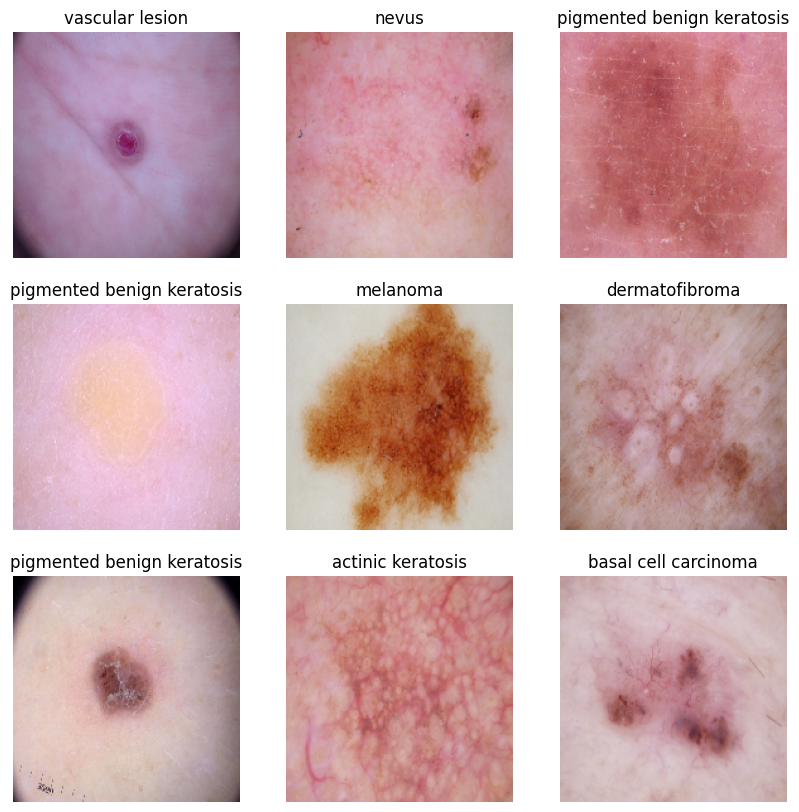

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [13]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

### Train the model

In [16]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 22s 117ms/step - loss: -72325.0156 - accuracy: 0.1713 - val_loss: -65850.1797 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 5s 81ms/step - loss: -786132.6875 - accuracy: 0.1724 - val_loss: -824396.4375 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 5s 82ms/step - loss: -2883524.2500 - accuracy: 0.1724 - val_loss: -2342914.2500 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 4s 79ms/step - loss: -7001990.5000 - accuracy: 0.1724 - val_loss: -6987476.0000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 5s 82ms/step - loss: -14074314.0000 - accuracy: 0.1724 - val_loss: -18095722.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 4s 79ms/step - loss: -24539802.0000 - accuracy: 0.1724 - val_loss: -29448460.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - los

### Visualizing training results

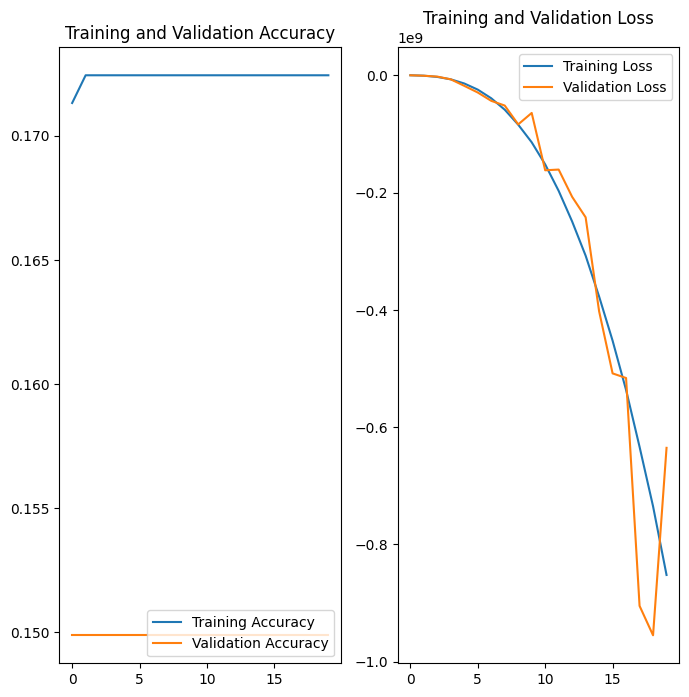

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model Overfit or Underfit?

In [18]:

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

14/14 [==============================] - 0s 24ms/step - loss: -635445056.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -621844608.0
Validation Loss -635445056.0


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False,  
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=10,  
    zoom_range=0.1,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=False,  
    vertical_flip=False,
    rescale=1./255  # Normalizing pixel values between 0 and 1
)

# No augmentation for validation data, just rescale
valid_datagen = ImageDataGenerator(rescale=1./255)

# Directory paths (assuming data_dir_train and data_dir_test are defined)
image_class = ['actinic keratosis', 
               'basal cell carcinoma', 
               'dermatofibroma',
               'melanoma',
               'nevus',
               'pigmented benign keratosis', 
               'seborrheic keratosis', 
               'squamous cell carcinoma',
               'vascular lesion']

# Creating the train_batches with augmentation
train_batches = train_datagen.flow_from_directory(
    data_dir_train, 
    target_size=(180, 180),
    classes=image_class,
    batch_size=64,
    class_mode='categorical'  # Assuming categorical labels for multiclass classification
)

# Creating the valid_batches without augmentation, just rescaling
valid_batches = valid_datagen.flow_from_directory(
    data_dir_test, 
    target_size=(180, 180),
    classes=image_class,
    batch_size=64,
    class_mode='categorical'
)


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


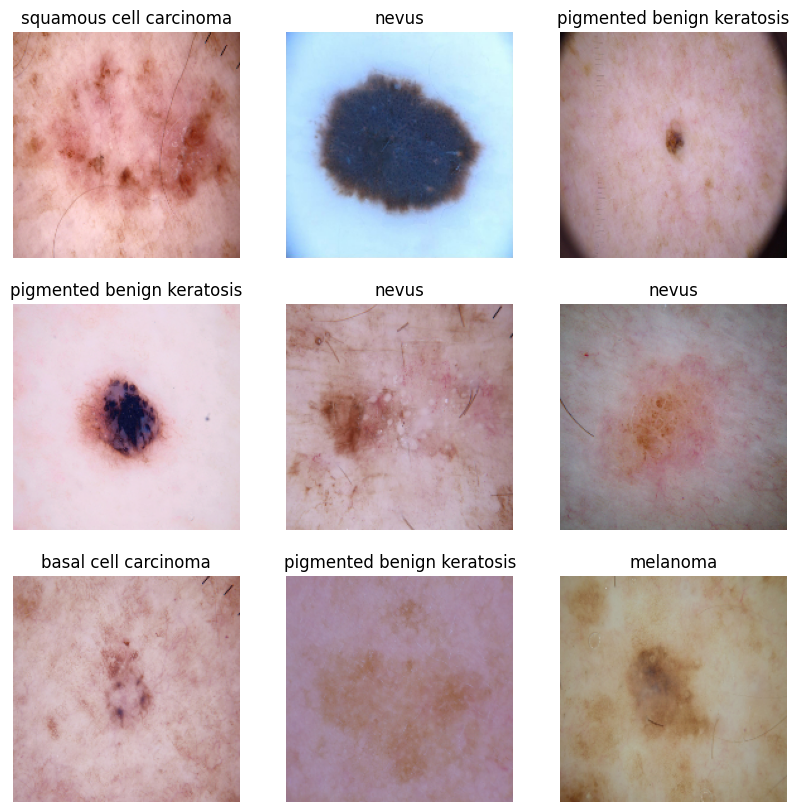

In [20]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Create the model, compile and train the model

In [46]:
import scipy  # Import scipy to ensure it's available
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the model
model = Sequential()

# Input shape is (180, 180, 3)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))  # Output: (90, 90, 32)
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))  # Output: (45, 45, 64)
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  # Output: (22, 22, 128)
model.add(Dropout(0.4))

# Flatten layer will convert (22, 22, 128) to a 1D vector of size 22 * 22 * 128 = 61952
model.add(Flatten())  # Output: 61952

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output layer for 9 classes
model.add(Dense(9, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_26 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 conv2d_28 (Conv2D)          (None, 90, 90, 64)        36928     
                                                      

### Compiling the model

In [47]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [49]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,  # Augmentations
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data should only be rescaled (no augmentation)
valid_datagen = ImageDataGenerator(rescale=1./255)


# Paths to the dataset
data_dir_train = r"C:\Users\nikhi\Dropbox\AI_ML_learning\AI_ML_Classes\Class_18_Melanoma_Detection\CNN_assignment\Skin_data\Train"
data_dir_test = r"C:\Users\nikhi\Dropbox\AI_ML_learning\AI_ML_Classes\Class_18_Melanoma_Detection\CNN_assignment\Skin_data\Test"

# Load the training data (make sure directory paths are correct)
train_batches = train_datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(180, 180),  # Input size matches the model's input shape
    batch_size=10,
    class_mode='categorical'  # Assuming multiple classes
)

# Load the validation data
valid_batches = valid_datagen.flow_from_directory(
    directory=data_dir_test,
    target_size=(180, 180),  # Input size matches the model's input shape
    batch_size=10,
    class_mode='categorical'
)


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [50]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    patience=2,          # Number of epochs with no improvement
    verbose=1,           # Display messages
    factor=0.5,          # Reduce the learning rate by a factor of 0.5
    min_lr=0.00001       # Minimum learning rate
)


In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

### Training the model

In [51]:
from scipy import ndimage  # Used for image augmentations


In [52]:
import scipy
from scipy import ndimage

print("scipy imported successfully!")


scipy imported successfully!


In [53]:
# Train the model
epochs = 20
batch_size = 10
history = model.fit(
    train_batches,
    epochs=epochs,
    verbose=1,
    validation_data=valid_batches,
    callbacks=[learning_rate_reduction]
)


Epoch 1/20
224/224 [==============================] - 75s 334ms/step - loss: 2.0358 - accuracy: 0.1983 - val_loss: 2.2319 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 2/20
224/224 [==============================] - 77s 343ms/step - loss: 2.0121 - accuracy: 0.2126 - val_loss: 2.2391 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 3/20
224/224 [==============================] - ETA: 0s - loss: 2.0375 - accuracy: 0.2014
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
224/224 [==============================] - 75s 332ms/step - loss: 2.0375 - accuracy: 0.2014 - val_loss: 2.2785 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 4/20
224/224 [==============================] - 76s 339ms/step - loss: 2.0250 - accuracy: 0.1938 - val_loss: 2.2797 - val_accuracy: 0.1356 - lr: 5.0000e-04
Epoch 5/20
224/224 [==============================] - 78s 346ms/step - loss: 2.0231 - accuracy: 0.2054 - val_loss: 2.2271 - val_accuracy: 0.1356 - lr: 5.0000e-04
Epoch 6/20
224/224 [=====================

<built-in method keys of dict object at 0x000001CC4C4CDD40> :


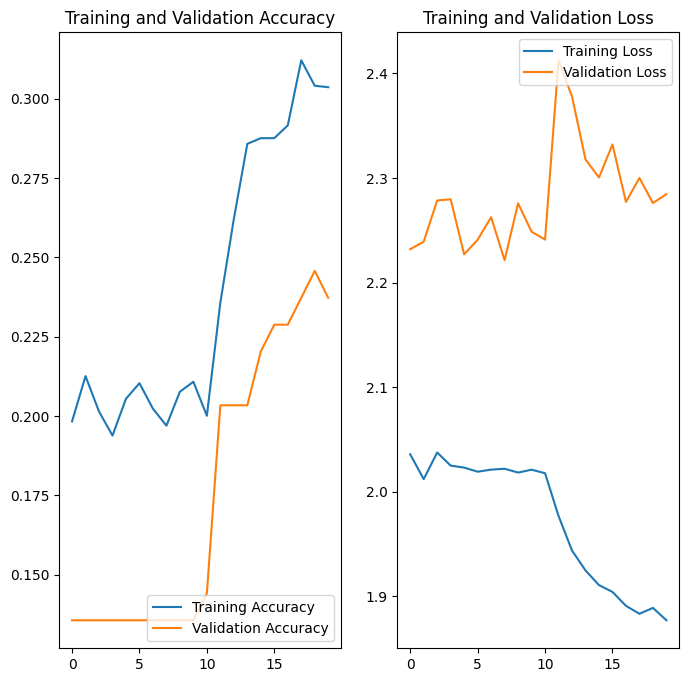

In [54]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
# Evaluate the model on the training data
loss, accuracy = model.evaluate(train_batches, verbose=1)
print("Training Accuracy: ", accuracy)
print("Training Loss: ", loss)

# Evaluate the model on the validation data
loss_v, accuracy_v = model.evaluate(valid_batches, verbose=1)
print("Validation Accuracy: ", accuracy_v)
print("Validation Loss: ", loss_v)


224/224 [==============================] - 64s 285ms/step - loss: 1.8770 - accuracy: 0.3064
Training Accuracy:  0.3063867688179016
Training Loss:  1.8770496845245361
12/12 [==============================] - 9s 743ms/step - loss: 2.2846 - accuracy: 0.2373
Validation Accuracy:  0.23728813230991364
Validation Loss:  2.284621477127075


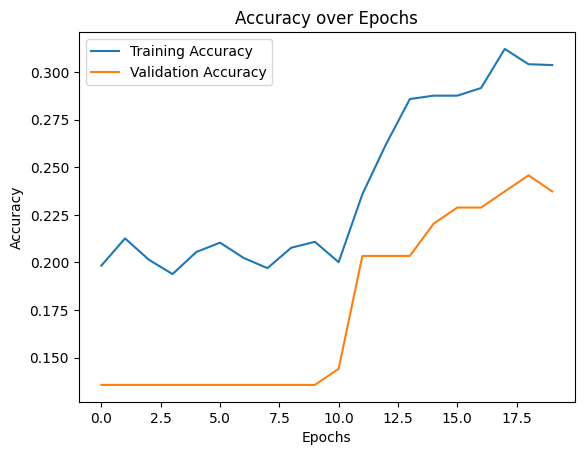

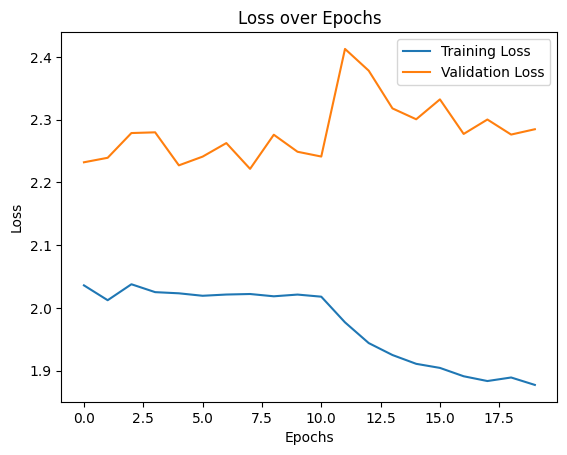

In [57]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [58]:
model.save('my_skin_cancer_model.h5')


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

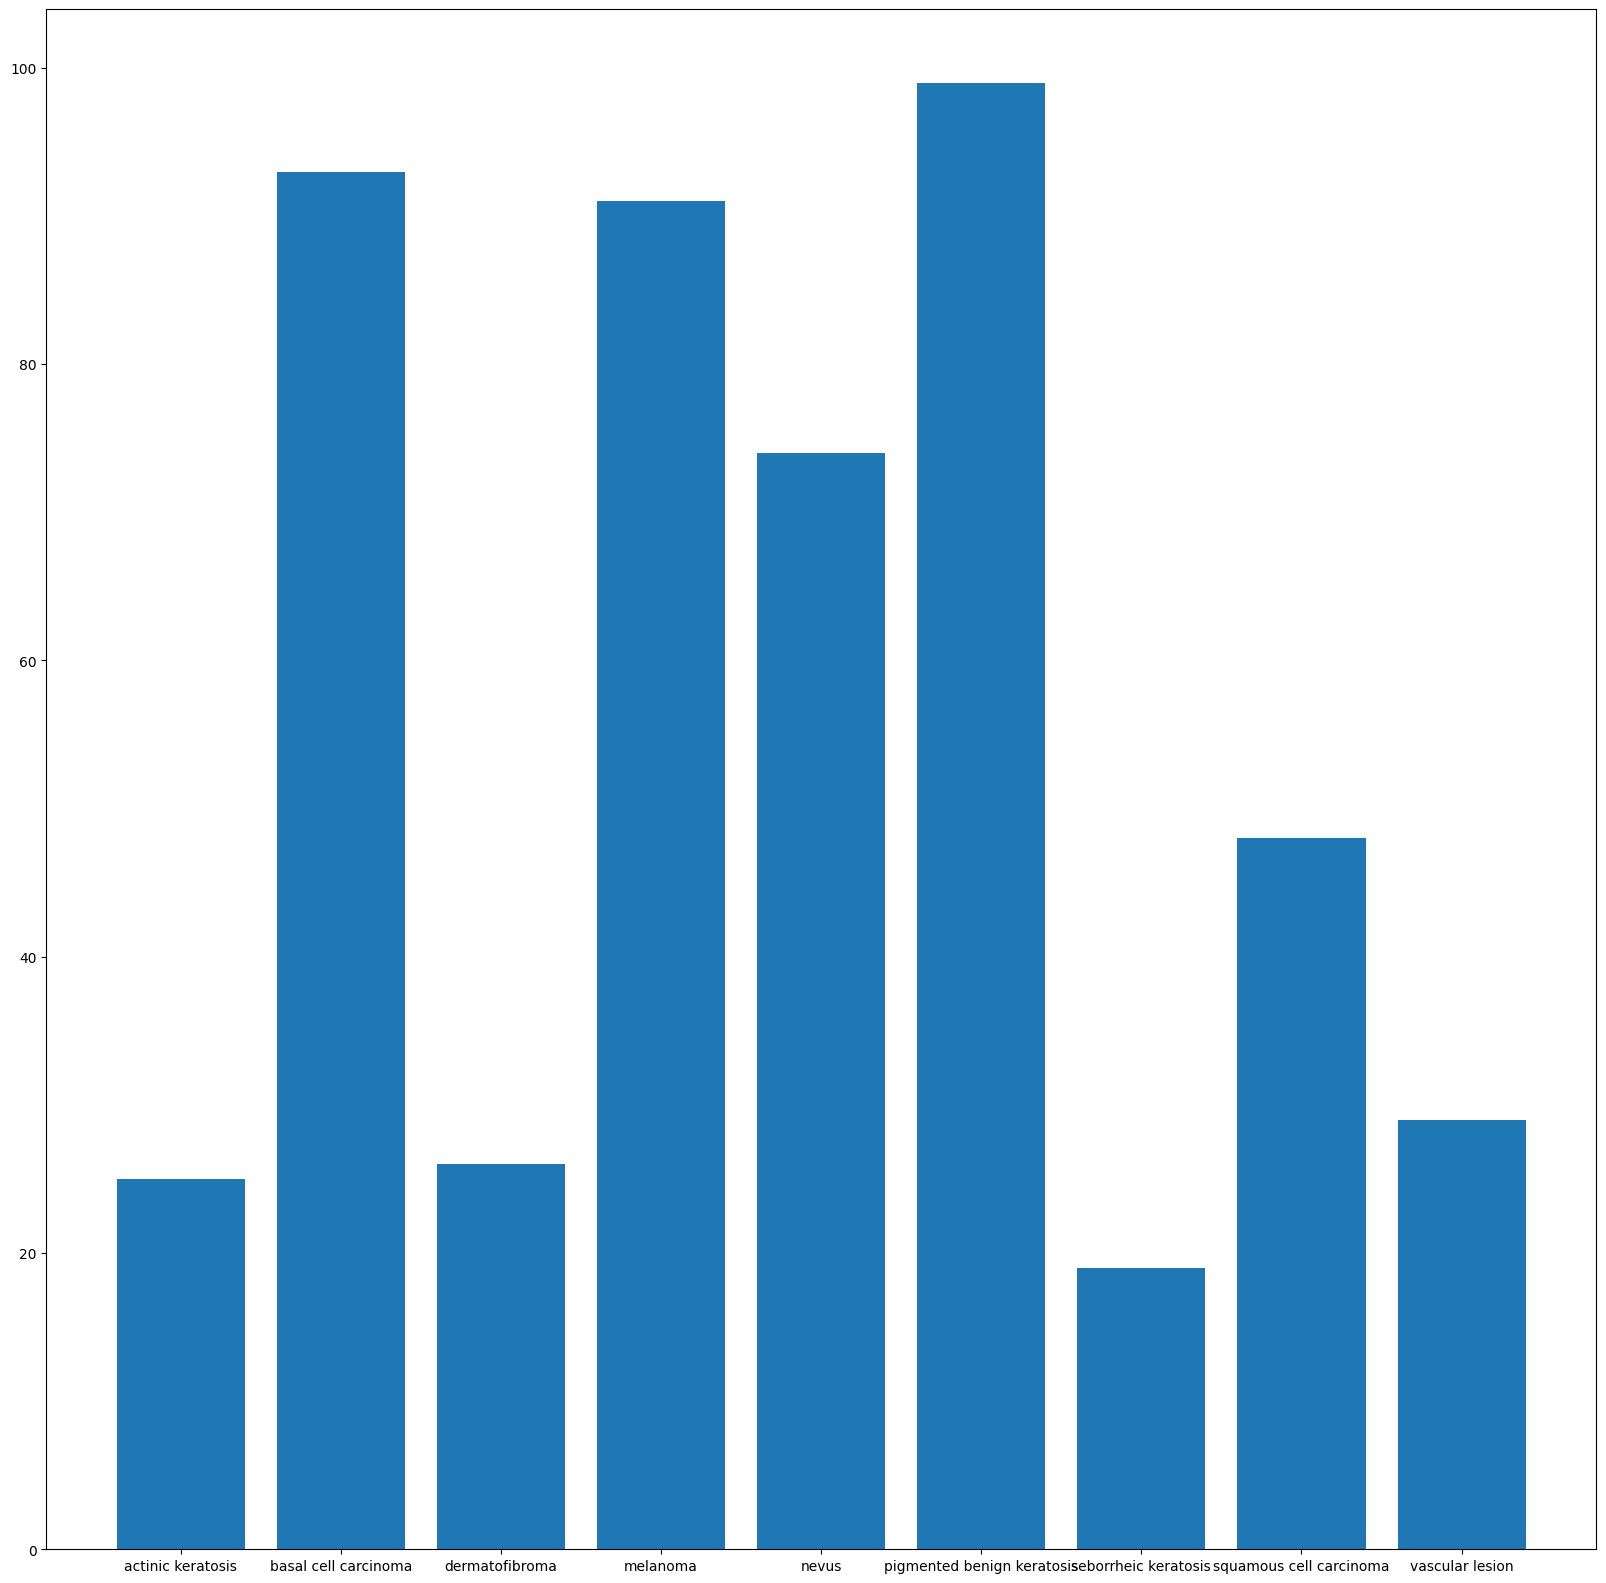

In [59]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.


#### - Which class has the least number of samples? - **Actinic Keratosos** and **Seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples?
**Pigmented benign keratosis** dominates the data of count more than 100 in training


In [60]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [68]:
import Augmentor
import os

# Path to the training dataset
path_to_training_dataset = r"C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train/"

# Class names (ensure these are the names of the subdirectories inside the Train directory)
class_names = ['actinic keratosis', 
               'basal cell carcinoma', 
               'dermatofibroma',
               'melanoma',
               'nevus',
               'pigmented benign keratosis', 
               'seborrheic keratosis', 
               'squamous cell carcinoma',
               'vascular lesion']

# Iterate through each class and augment the data
for class_name in class_names:
    # Create a pipeline for each class
    class_path = os.path.join(path_to_training_dataset, class_name)
    p = Augmentor.Pipeline(class_path)
    
    # Add augmentation operations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    
    # Generate 500 new samples for this class
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CC3CAF9DB0>: 100%|█| 500/500 [00:04<00:00, 112.94 Samples


Initialised with 376 image(s) found.
Output directory set to C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CC3CA12470>: 100%|█| 500/500 [00:04<00:00, 114.86 Samples


Initialised with 95 image(s) found.
Output directory set to C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CC4DE2F250>: 100%|█| 500/500 [00:04<00:00, 120.74 Samples


Initialised with 438 image(s) found.
Output directory set to C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CC3D023190>: 100%|█| 500/500 [00:21<00:00, 23.33 Samples


Initialised with 357 image(s) found.
Output directory set to C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CC3CFFBF70>: 100%|█| 500/500 [00:19<00:


Initialised with 462 image(s) found.
Output directory set to C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CC4DD50F10>: 100%|█| 500/500 [00:04<00:00, 115.63 Samples


Initialised with 77 image(s) found.
Output directory set to C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CC345A0610>: 100%|█| 500/500 [00:09<00:00, 53.91 Samples


Initialised with 181 image(s) found.
Output directory set to C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CC4CAFAB30>: 100%|█| 500/500 [00:04<00:00, 120.37 Samples


Initialised with 139 image(s) found.
Output directory set to C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CC4DD3D900>: 100%|█| 500/500 [00:04<00:


In [69]:
from pathlib import Path

# Path to the training dataset
data_dir_train = Path(r"C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train")

# Counting images in all 'output' folders within each class
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(f"Total number of augmented images in Train folder: {image_count_train}")


Total number of augmented images in Train folder: 4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [70]:
import os
import glob

# Path to the training dataset
data_dir_train = r"C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train"

# Get all .jpg files in the 'output' folder inside each class directory
path_list = glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))

# Print the list of paths (or inspect it)
print(path_list)


['C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0daf0f07-a4f2-46c9-bdd0-6971847b3dba.jpg', 'C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1ab074bf-e16f-4ce3-b958-e36d674c7386.jpg', 'C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_713b9445-eff3-4df2-a8cb-42f276742633.jpg', 'C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_383a3b3f-2f1e-413a-ad19-42145328fb31.jpg', 'C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assign

In [72]:
import os
import glob

# Path to the training dataset
data_dir_train = r"C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train"

# Get all .jpg files in the 'output' folder inside each class directory
jpg_files = glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))

# Extract the lesion (class) folder names two levels up from the .jpg files
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in jpg_files]

# Print the lesion class names
print(lesion_list_new)


['actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic ker

In [73]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [74]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [75]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor


In [77]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [78]:
data_dir_train = r"C:/Users/nikhi/Dropbox/AI_ML_learning/AI_ML_Classes/Class_18_Melanoma_Detection/CNN_assignment/Skin_data/Train"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [79]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization

# Define the input shape for 180x180 RGB images
input_shape = (180, 180, 3)  # Update input shape to (180, 180, 3)
num_classes = 9  # Change this based on the number of classes in your dataset

# Define the model
model = Sequential()

# First block: Conv2D layers with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Second block: Conv2D layers with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Third block: Conv2D layers with 128 filters
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten layer to convert 3D tensor to 1D
model.add(Flatten())

# Fully connected layer with 128 units
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer for multi-class classification
model.add(Dense(num_classes, activation='softmax'))  # For multi-class classification

# Model summary
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_36 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 90, 90, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_28 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 90, 90, 64)       

#### Compile your model (Choose optimizer and loss function appropriately)

In [87]:
import tensorflow as tf

# Example integer-encoded labels for 9 classes
y_train = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Replace with actual labels from your dataset

# One-hot encode the labels
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=9)  # One-hot encode the labels for 9 classes

# Use y_train_one_hot in your dataset creation
print(y_train_one_hot)



[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [88]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

####  Train your model

In [93]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Correctly define the ReduceLROnPlateau callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

# Make sure learning_rate_reduction is not None
print(learning_rate_reduction)  # This should not print None


In [97]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)


In [98]:
from tensorflow.keras import backend as K
K.clear_session()


In [101]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Clear the previous session
K.clear_session()

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Initialize data batches (check for valid directory paths)
train_batches = train_datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(180, 180),
    batch_size=10,
    class_mode='categorical'
)

valid_batches = valid_datagen.flow_from_directory(
    directory=data_dir_test,
    target_size=(180, 180),
    batch_size=10,
    class_mode='categorical'
)

# Ensure train_batches and valid_batches are not None
print(train_batches)
print(valid_batches)

# Define the learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

# Check that the callback is not None
print(learning_rate_reduction)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(
    train_batches,
    epochs=50,
    verbose=1,
    validation_data=valid_batches,
    callbacks=[learning_rate_reduction]
)


Found 6739 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
Epoch 1/50
674/674 [==============================] - 58s 85ms/step - loss: 1.3113 - accuracy: 0.5078 - val_loss: 1.9508 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 2/50
674/674 [==============================] - 54s 80ms/step - loss: 1.3005 - accuracy: 0.5109 - val_loss: 1.9773 - val_accuracy: 0.3644 - lr: 0.0010
Epoch 3/50
674/674 [==============================] - 56s 83ms/step - loss: 1.2950 - accuracy: 0.5069 - val_loss: 2.6429 - val_accuracy: 0.3559 - lr: 0.0010
Epoch 4/50
674/674 [==============================] - 57s 84ms/step - loss: 1.2895 - accuracy: 0.5213 - val_loss: 1.8031 - val_accuracy: 0.4322 - lr: 0.0010
Epoch 5/50
674/674 [==============================] - 58s 86ms/step - loss: 1.2612 - accuracy: 0.5266 - val_loss: 2.4148 - val_accuracy: 0.3390 - lr: 0.0010
Epoch 6/50
674/674 [==============================] - 58s 85ms/step - loss: 1.2245 - accuracy: 0.5373 - val_loss: 2.0231 - val_accur

####  Visualize the model results

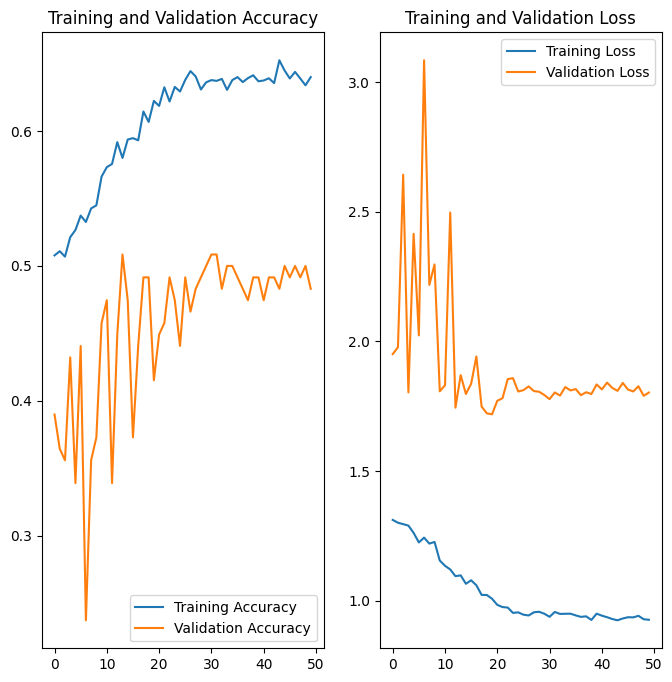

In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Did you get rid of underfitting/overfitting? Did class rebalance help?


The class rebalance helped in reducing overfititng of the data and thus the loss is beng reduced

Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

Then we introduced dropout and ImageDataGenerator which reduced the over fit

At last we tried Batch Normalization and Augumentation which really helped in carry forward